In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
from scipy import stats

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

In [2]:
def tif2array(file_path, dtype=np.uint8):
    """
    read GeoTiff and convert to numpy.ndarray.
    inputs:
        file_path (str) : file path of the input GeoTiff file
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive
    """
    dataset = gdal.Open(file_path, gdal.GA_ReadOnly)

    if dataset is None:
        return None

    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=dtype)

    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()#buf_type=gdalconst.GDT_Byte)

    #image = image[2:-2,2:-2,:]

    return image

In [3]:
def array2raster(newRasterfn, dataset, array, dtype, offsetX=0, offsetY=0):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    originX += offsetX
    originY += offsetY

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Int16":
        GDT_dtype = gdal.GDT_Int16
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [4]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth_eos.h5'

hdf5_modis = h5py.File(path_hdf5, 'r')

(1299, 1864)


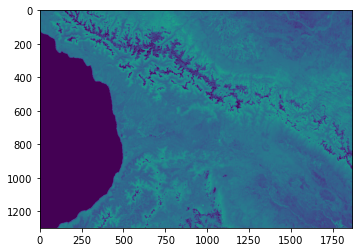

In [5]:
mean = np.mean(hdf5_modis['SOS'][:,:,1:], axis=2)
std = np.std(hdf5_modis['SOS'][:,:,1:], axis=2)

maxi = np.max(hdf5_modis['SOS'][:,:,1:], axis=2)
mini = np.min(hdf5_modis['SOS'][:,:,1:], axis=2)
print(mean.shape)
plt.imshow(mean)

/tmp/ipykernel_5292/4121171336.py:2: RuntimeWarning: invalid value encountered in true_divide
  anom_rel = (hdf5_modis['SOS'][:,:,9] - mini) / (maxi - mini) * 100
/tmp/ipykernel_5292/4121171336.py:3: RuntimeWarning: invalid value encountered in true_divide
  anom_std = (hdf5_modis['SOS'][:,:,9] - mini) / (maxi - mini) * 100


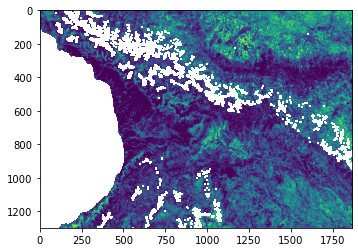

In [55]:
anom_abs = hdf5_modis['SOS'][:,:,9] - mean
anom_rel = (hdf5_modis['SOS'][:,:,9] - mini) / (maxi - mini) * 100
anom_std = (hdf5_modis['SOS'][:,:,9] - mini) / (maxi - mini) * 100
plt.imshow(anom_std)

In [56]:
calc_type = 'sos_diff_std'
pheno_key = 'SOS'

# convert numpy array to geotiff files
for i in range(1, 12):
    # create input path
    path_in = '/home/philipp/Data/modis/raw/MOD13Q1.A2009001.250m_16_days_NDVI.tif'
    # create output path
    path_out = '/home/philipp/Data/modis/sos/georgia_{}_{}.tif'.format(calc_type, 2009+i)
    # open coresponding ortho file
    dataset = gdal.Open(path_in, gdal.GA_ReadOnly)
    
    if calc_type == 'sos_diff_abs':
        data = hdf5_modis[pheno_key][:,:,i] - mean
    elif calc_type == 'sos_diff_rels':
        data = (hdf5_modis[pheno_key][:,:,i] - mini) / (maxi - mini) * 100
    elif calc_type == 'sos_diff_std':
        data = (hdf5_modis[pheno_key][:,:,i] - mean) / std
    else:
        break
        
    # create rater (GeoTiff) file out of numpy array (prediction) and coresponding ortho file information  
    array2raster(newRasterfn=path_out, dataset=dataset, array=data, dtype='Int16', offsetX=0, offsetY=0)

print('finished')

del data

/tmp/ipykernel_5292/3008270664.py:18: RuntimeWarning: invalid value encountered in true_divide
  data = (hdf5_modis[pheno_key][:,:,i] - mean) / std
ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: pr

finished


ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/env

In [164]:
sos_111 = []

for i in range(1,12):
    sos_111.append(hdf5_modis['LOS'][:,27:,i].flatten())
    
sos_111 = np.array(sos_111)

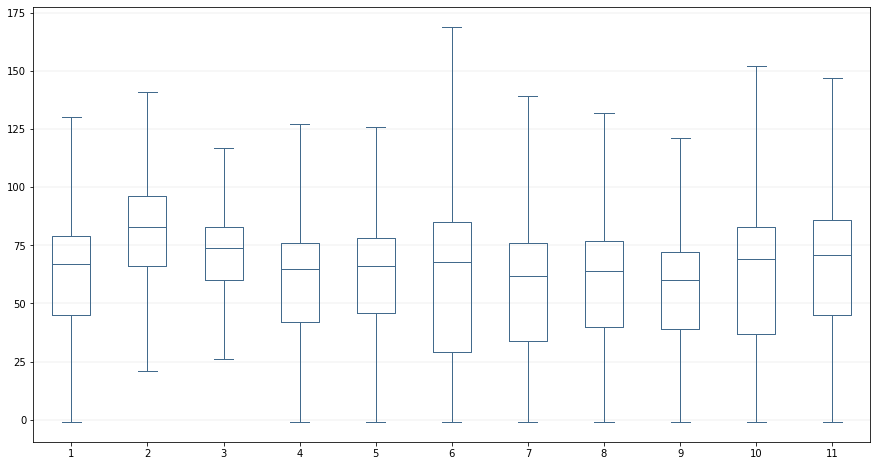

In [162]:
colors_setosa = dict(color='#426A8C')
                            # #73020C, '#426A8C', '#D94D1A'])

ig, ax = plt.subplots(figsize=(15, 8))

ax.boxplot(np.transpose(sos_111), showfliers=False, boxprops=colors_setosa, medianprops=colors_setosa, whiskerprops=colors_setosa, capprops=colors_setosa, flierprops=colors_setosa)
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.show()

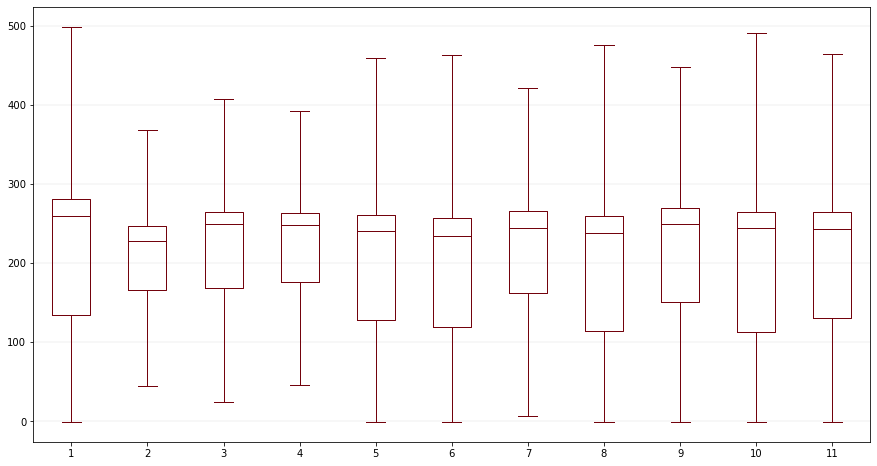

In [165]:
colors_setosa = dict(color='#73020C')
                            # #73020C, '#426A8C', '#D94D1A'])

ig, ax = plt.subplots(figsize=(15, 8))

ax.boxplot(np.transpose(sos_111), showfliers=False, boxprops=colors_setosa, medianprops=colors_setosa, whiskerprops=colors_setosa, capprops=colors_setosa, flierprops=colors_setosa)
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.show()

### Altitude

In [5]:
file_path = "/home/philipp/Data/modis/aligned/georgia_region/lc_2019.tif"
lc = tif2array(file_path, dtype=np.int16)
file_path = "/home/philipp/Data/modis/aligned/georgia_region/koeppen.tif"
koeppen = tif2array(file_path, dtype=np.int16)
file_path = "/home/philipp/Data/modis/aligned/georgia_region/dem.tif"
dem = tif2array(file_path, dtype=np.int16)

In [6]:
file_path = "/home/philipp/Data/modis/aligned/georgia_clipped/mask.tif"
mask = tif2array(file_path, dtype=np.int8)

In [12]:
mask[mask==-1] = 0

In [15]:
mask.shape

(1299, 1837, 1)

In [17]:
# create input path
path_in = '/home/philipp/Data/modis/aligned/georgia_clipped/mask.tif'
# create output path
path_out = '/home/philipp/Data/modis/aligned/georgia_clipped/mask0.tif'
# open coresponding ortho file
dataset = gdal.Open(path_in, gdal.GA_ReadOnly)
# create rater (GeoTiff) file out of numpy array (prediction) and coresponding ortho file information  
array2raster(newRasterfn=path_out, dataset=dataset, array=mask[:,:,0], dtype='Int8', offsetX=0, offsetY=0)


Not supported data type.


ERROR 1: TIFFScanlineSize64:Computed scanline size is zero
ERROR 1: PROJ: createGeodeticReferenceFrame: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_as_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_wkt: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /home/philipp/software/conda3/envs/modis/share/proj failed
ERROR 1: TIFFScanlineSize64:Computed scanline size is zero
ERROR 1: TIFFScanlineSize64:Computed scanline size is zero
ERROR 1: TIFFReadDirectory:Cannot handle zero scanline size
ERROR 1: TIFFScanlineSize64:Computed sca

In [13]:
file_path = "/home/philipp/Data/modis/aligned/georgia_clipped/mask0.tif"
array2raster(file_path, mask)

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=int8)

In [6]:
dem.shape

(1299, 1837, 1)

In [7]:
np.unique(dem)

array([ -23,  -21,  -16, ..., 5582, 5592, 5597], dtype=int16)

In [10]:
mean[:,27:].shape

(1299, 1837)

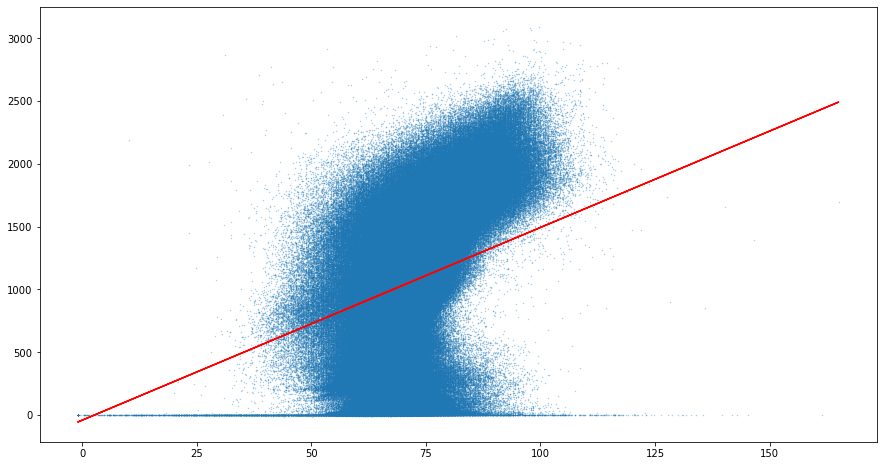

In [166]:
# filter just forest
idxs_114 = np.where(lc.flatten()>100)

# set SOS
x = mean[:,27:].flatten()[idxs_114]
# set DEM
y = dem.flatten()[idxs_114]

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(x, y, alpha=0.4, s=0.2)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color='red')

In [96]:
slope, intercept, r, p, std_err = stats.linregress(x, y)
r

0.759638686159795

### NDVI

In [8]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth.h5'

ndvi = h5py.File(path_hdf5, 'r')

In [ ]:
ndvi_all = []

for i in range(1,12):
    ndvi_all.append(ndvi['whittaker'][:,27:,365*i:365*(i+1)])
    
ndvi_all = np.array(ndvi_all)

In [ ]:
ndvi_all.shape

In [9]:
ndvi_2010 = ndvi['whittaker'][:,27:,365:365*2]

In [10]:
ndvi_2010.shape

(1299, 1837, 365)

In [13]:
ndvi_2010 = np.reshape(ndvi_2010, (-1,365))

In [14]:
ndvi_2010.shape

(2386263, 365)

In [15]:
lc_types = np.unique(lc)
lc_types

array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 111, 114, 115, 116,
       121, 124, 125, 126, 200], dtype=int16)

#### forest

In [16]:
lc_types = np.array([ 111, 114, 115, 116, 121, 124, 125, 126])

In [17]:
ndvi_mean = {}

for lc_type in lc_types:
    idxs = np.where(lc.flatten()==lc_type)
    
    ndvi_mean[lc_type] = np.mean(ndvi_2010[idxs], axis=0)

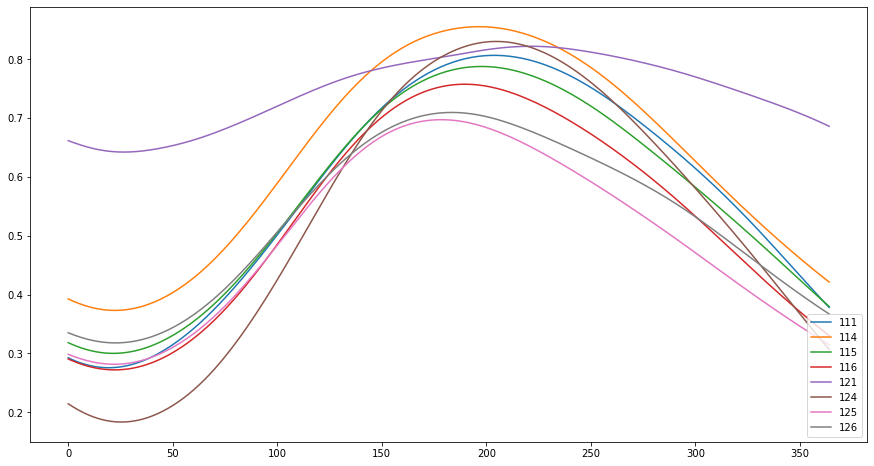

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))

for lc_type in lc_types:
    ax.plot(ndvi_mean[lc_type], label=str(lc_type))

ax.legend(loc='lower right')

#### lc types

In [19]:
lc_types = np.array([20,  30,  40,  50,  60,  70,  80,  90, 100, 200])

In [20]:
ndvi_mean = {}

for lc_type in lc_types:
    idxs = np.where(lc.flatten()==lc_type)
    
    ndvi_mean[lc_type] = np.mean(ndvi_2010[idxs], axis=0)

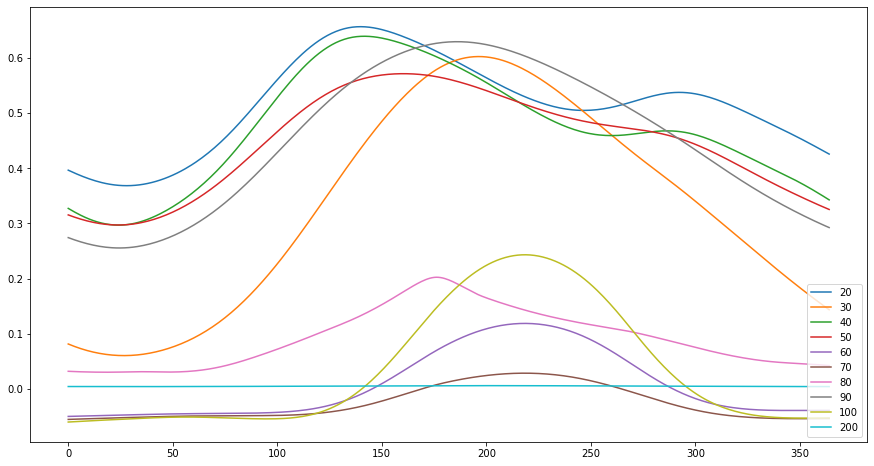

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

for lc_type in lc_types:
    ax.plot(ndvi_mean[lc_type], label=str(lc_type))

ax.legend(loc='lower right')

In [22]:
#ndvi_min = {}
ndvi_mean = {}
ndvi_std = {}

for lc_type in [111,114]:
    idxs = np.where(lc.flatten()==lc_type)

    ndvi_mean[lc_type] = np.mean(ndvi_2010[idxs], axis=0)
    ndvi_std[lc_type] = np.std(ndvi_2010[idxs], axis=0)

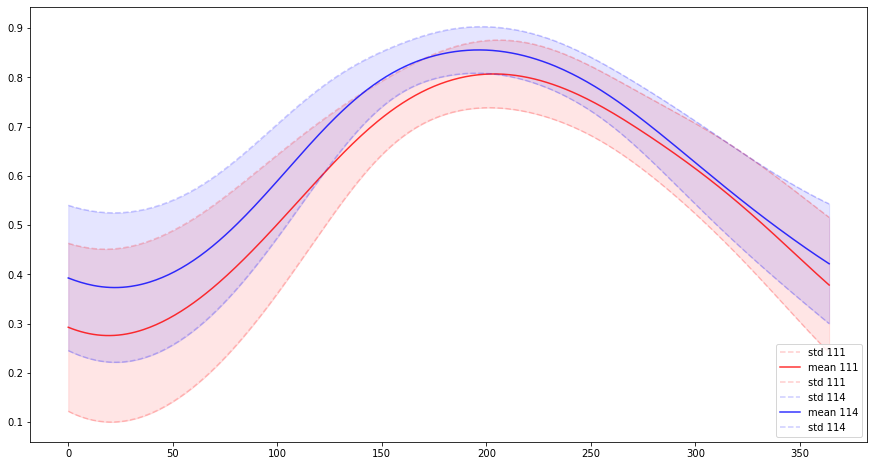

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))

for lc_type in [111,114]:
    color = 'red' if lc_type==111 else 'blue'
    ax.plot(ndvi_mean[lc_type]+ndvi_std[lc_type], label='std '+str(lc_type), color=color, ls='--', alpha=0.2)
    ax.plot(ndvi_mean[lc_type], label='mean '+str(lc_type), color=color, alpha=0.8)
    ax.plot(ndvi_mean[lc_type]-ndvi_std[lc_type], label='std '+str(lc_type), color=color, ls='--', alpha=0.2)
    
    ax.fill_between(np.arange(0,365), ndvi_mean[lc_type]+ndvi_std[lc_type], ndvi_mean[lc_type]-ndvi_std[lc_type], alpha=0.1, color=color)

ax.legend(loc='lower right')